<a href="https://colab.research.google.com/github/vincebarokie/crypto_model/blob/main/crypto_price_machine_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Crypto Price Machine Learning Model

Submitted By: Raymund Vincent Ricabar

**Dataset** is found [here](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset)

This dataset was extracted using web scraping and various python packages like investpy, yahoo finance, pandas data reader.

**TODOS**

- [x] EDA on trending & potential of the Celo (can by any cryptocurrency)
- [x] Predict prices (close) of Celo (can be any cryptocurrency) 
- [x] Plot true value and predicted value over time
- [x] create a presentation for non-technical audience

|No |	Columns	| Descriptions |
|:--|---------|--------------:|
|1	|Date	|Date of the crypto prices|
|2	|Close	|Closing prices of crypto(dollars)|
|3	|Open	|Opening price of crypto on the respective date(Dollars)|
|4	|High	|Highest price of crypto on the respective date(Dollars)|
|5	|Low	|Lowest price of crypto on the respective date(Dollars)|
|6	|Vol.	|Volume of crypto on the respective date(Dollars)|

## Data Cleaning

We will be setting our imports, loading our dataset and perform some initial data exploration in this section.

In [1]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [2]:
# imports
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# imputing
from sklearn.impute import SimpleImputer

# preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

# clustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# modeling
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# metrics and evaluation
from sklearn.metrics import silhouette_score, classification_report, ConfusionMatrixDisplay, \
mean_squared_error, mean_absolute_error, r2_score

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**My Custom Functions**

In [3]:
# model performance evulation function
def evaluate_model(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  # print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')
  return {"r2": r2, "mae": mae, "mse": mse, "rmse": rmse}

def actual_preds_plot(X_test, xaxis, actual, preds):
  # line plot of crypto price over time
  fig, ax = plt.subplots(figsize = (10, 5))
  ax = sns.lineplot(x = X_test[xaxis], y = X_test[actual])
  ax = sns.lineplot(x = X_test[xaxis], y = X_test[preds])
  ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
  plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
  plt.legend(labels = ['actual', 'predictions'], loc = 'best')
  plt.show()

In [29]:
# this code block was grabed from the class notes link below : 
# https://colab.research.google.com/drive/19rXmqAs2G5m1DXknfuT_KV1hYFSAgOrZ
# You can use this function to see how your model improves over time
def plot_history(history, metric=None, format = True):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  if format:
    axes[0].ticklabel_format(useOffset = False, axis = 'y', style = 'plain')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    if format:
      axes[1].ticklabel_format(useOffset = False, axis = 'y', style = 'plain')
    axes[1].legend()

  plt.show()

In [4]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/CodingDojo_DS/dataset_files/Celo.csv', index_col = 'Date')
df.drop(columns = 'Currency', inplace = True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-05-22,0.825951,0.978356,0.795534,0.832663,2019357
2020-05-23,0.832773,2.516911,0.832773,2.496207,3645282
2020-05-24,2.431673,3.916595,1.470536,1.813446,3305900
2020-05-25,1.809696,1.935927,1.426814,1.436379,2211306
2020-05-26,1.436503,1.945482,1.424429,1.522619,2323976


In [5]:
# check for duplicates and missing values
print(f'Dataset has {df.duplicated().sum()} duplicated rows!')
print('\n')
df.info()

Dataset has 0 duplicated rows!


<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 2020-05-22 to 2022-05-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    718 non-null    float64
 1   High    718 non-null    float64
 2   Low     718 non-null    float64
 3   Close   718 non-null    float64
 4   Volume  718 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 33.7+ KB


This dataset does not have any duplicated rows and no missing values and seems ready for EDA.

In [6]:
# index to datetime
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-05-22,0.825951,0.978356,0.795534,0.832663,2019357
2020-05-23,0.832773,2.516911,0.832773,2.496207,3645282
2020-05-24,2.431673,3.916595,1.470536,1.813446,3305900
2020-05-25,1.809696,1.935927,1.426814,1.436379,2211306
2020-05-26,1.436503,1.945482,1.424429,1.522619,2323976


We droped Currency column as it is all USD and will not affect our model in any way. 

In [7]:
# check statistical description
df.describe()

,Open,High,Low,Close,Volume
count,718.000000,718.000000,718.000000,718.000000,7.180000e+02
mean,3.346751,3.570749,3.179134,3.348504,5.896924e+07
std,1.432539,1.556427,1.345977,1.430457,1.075233e+08
min,0.825951,0.978356,0.795534,0.832663,1.084620e+05
25%,2.131466,2.253136,2.032053,2.130162,4.256354e+06
50%,3.070866,3.204268,2.919805,3.069282,2.992759e+07
75%,4.371144,4.691058,4.143291,4.366647,7.138072e+07
max,7.616765,10.658358,7.061696,7.638003,1.385377e+09


Mean Price(Close) of Celo is at 3.34 USD and the Volumne 

## Exploratory Data Analysis

We will be performing some initial data visualization in this section.

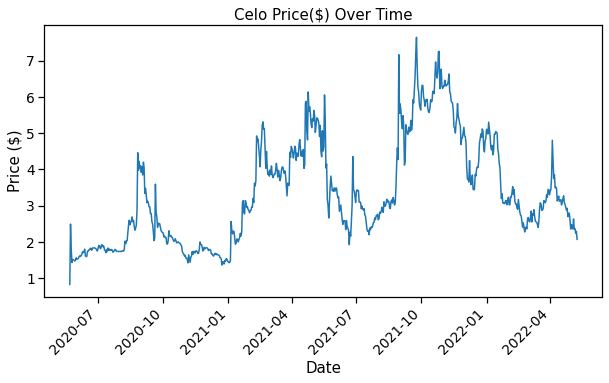

In [8]:
# line plot of crypto price over time
sns.set_context('notebook', font_scale = 1.25)
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.lineplot(x = df.index, y = df['Close'])
ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
plt.show()

As seen in the visualization above, we can see that Celo Closing Price (applies to all crypto price) is very volatile and could be any price on a given time.

## Visualize as Crypto Trading via Plotly

* Code for this visualization is taken from this [resource](https://pythoninoffice.com/draw-stock-chart-with-python/).

In [9]:
# adding a column indicator 
plotly_df = df.copy()
plotly_df['diff'] = plotly_df['Close'] - plotly_df['Open']
plotly_df.loc[plotly_df['diff'] >= 0, 'color'] = 'green'
plotly_df.loc[plotly_df['diff'] < 0, 'color'] = 'red'

In [10]:
# plot trading view via plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=df['Date'], y = df['Close'], name = 'Price'), secondary_y = False)
fig.add_trace(go.Candlestick(x = plotly_df.index, 
                             open = plotly_df['Open'], 
                             high = plotly_df['High'], 
                             low = plotly_df['Low'],
                             close = plotly_df['Close'],
                             name = 'Price'
                             ))
fig.add_trace(go.Scatter(x = plotly_df.index, 
                         y = plotly_df['Close'].rolling(window=20).mean(), 
                         marker_color = 'blue', 
                         name = '20 Day MA'
                        ))
fig.add_trace(go.Bar(x=plotly_df.index, 
                     y = plotly_df['Volume'], 
                     name = 'Volume',
                     marker = {'color' : plotly_df['color']}
                     ), 
              secondary_y = True
              )
fig.update_yaxes(range = [0, 7000000000], secondary_y = True)
fig.update_yaxes(visible=False, secondary_y = True)
fig.update_layout(title = {'text': 'Celo Trading View', 'x' : 0.5})
# uncomment the line below to disable the range slider
fig.update_layout(xaxis_rangeslider_visible = False)
# fig.show('png') -> will be used to show a static view of the graph in GitHub, 
# fig.show() without any attribute will be used to make interactive in Google Colab.
fig.show()

*The visual above is a trading view of the Celo Price (Low, High and Close) daily, and the Volume by day (with green and red indicators). This also includes a 20 Day Moving Average (blue) one indicator that help traders decide whether to buy or sell or hold their assets.*

In [11]:
# save the graph above to html 
# fig.write_html(r'/content/drive/MyDrive/CodingDojo_DS/dataset_files/graph.html')

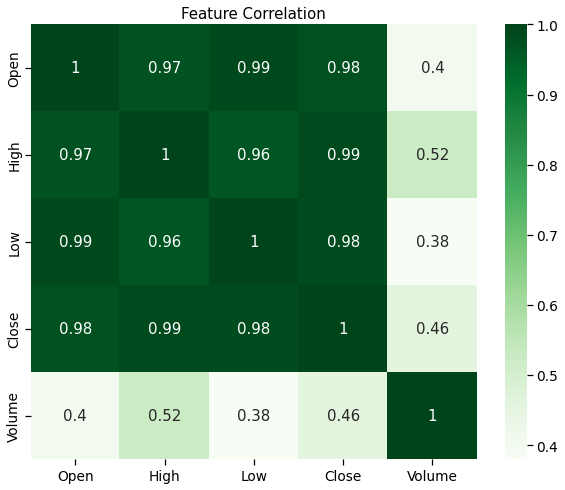

In [12]:
# heatmap plot of dimension correlation
corr = df.corr()
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr, cmap = 'Greens', annot = True)
ax.set(title = 'Feature Correlation')
plt.show()

Our data shows that prices (Open, Low, High and Closing) are greatly correlated and is also somewhat correlated to our Volume. 

## LSTM Model

In [20]:
# train test split for time series
test_ratio = 0.2
train_ratio = 1 - test_ratio

train_size = int(train_ratio * len(df))
test_size = int(test_ratio * len(df))

train = df[: train_size]
test = df[train_size :]

X_train, y_train = train.drop(columns = 'Close'), train['Close']
X_test, y_test = test.drop(columns = 'Close'), test['Close']

In [21]:
# preproc
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
def build_lstm_model(input_shape, neurons=50, dropout = 0.0, activation = 'sigmoid'):
  model = Sequential()
  # input layer
  model.add(LSTM(neurons, activation = activation, return_sequences=True, input_shape = input_shape, dropout = dropout))
  # hidden lstm layers
  model.add(LSTM(neurons, activation = activation, return_sequences=True, dropout = dropout))
  model.add(LSTM(neurons, activation = activation, return_sequences=False, dropout = dropout))
  # output layer
  model.add(Dense(1, activation = 'linear'))
  # compile 
  model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
  model.summary()
  
  return model

def fit_lstm(model, X_train, X_test, y_train, epochs, validation, verbose):
  history = model.fit(X_train_scaled, y_train, epochs = epochs, validation_data = validation, verbose = verbose)
  preds = model.predict(X_test)
  return history, preds

def plot_preds(test_data):
  fig, ax = plt.subplots(figsize = (20, 10))
  # plt.plot(train.index, train['Close'], label = 'Train Price')
  plt.plot(test_data.index, test_data['Close'], label = 'Test Price')
  plt.plot(test_data.index, test_data['preds'], label = 'Predictions')
  plt.xlabel('Date')
  plt.ylabel('Close Price ($)')
  plt.legend(loc = 'best')
  plt.title('Celo Price ($)', fontsize = 'x-large')
  plt.show()

In [48]:
# build model
input_shape = (X_train_scaled.shape[1], 1)
model = Sequential()
# input layer
model.add(LSTM(50, return_sequences=True, input_shape = input_shape))
# hidden lstm layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
# output layer
model.add(Dense(1, activation = 'linear'))
# compile 
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 4, 50)             10400     
                                                                 
 lstm_10 (LSTM)              (None, 4, 50)             20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train_scaled, y_train, epochs = 50, validation_data = [X_test_scaled, y_test])

Epoch 1/50
18/18 [==============================] - 10s 65ms/step - loss: 12.5260 - mse: 12.5260 - val_loss: 9.6296 - val_mse: 9.6296
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 5.7932 - mse: 5.7932 - val_loss: 0.7479 - val_mse: 0.7479
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5690 - mse: 0.5690 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 0.1967 - mse: 0.1967 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0395 - val_mse: 0.0395
Epoch 7/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 8/50
18/18 [==============================] - 0s 8ms/step - loss: 0.0587 - mse: 

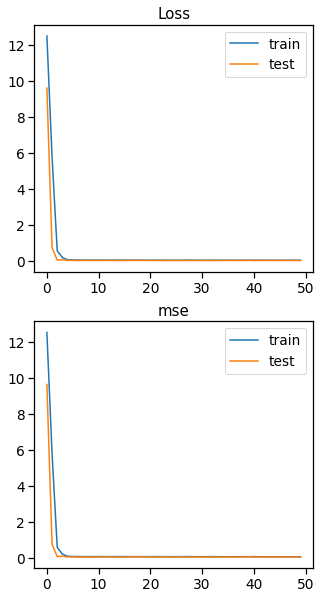

In [30]:
plot_history(history, 'mse')

In [39]:
_preds = model.predict(X_test_scaled)

evaluate_model(y_test, _preds)

{'mae': 0.12467088633113438,
 'mse': 0.033308975437715084,
 'r2': 0.9537457225658559,
 'rmse': 0.18250746679989585}

In [49]:
test['preds'] = _preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



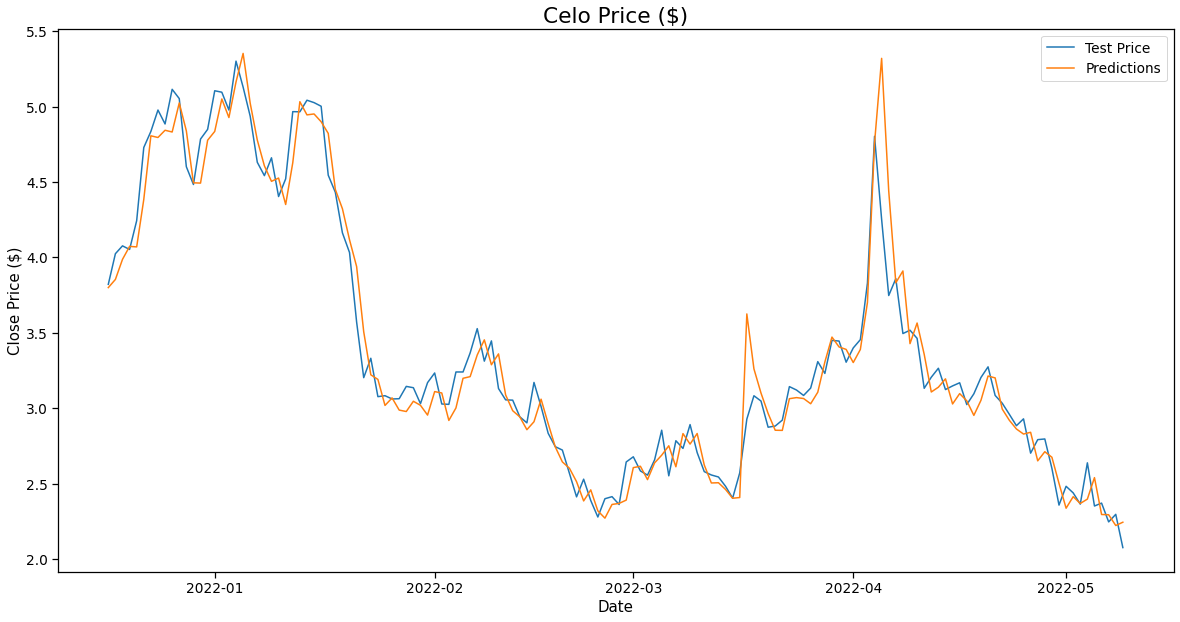

In [64]:
plot_preds(test)

In [72]:
model_2 = build_lstm_model(input_shape, activation = 'tanh', neurons = 50)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 4, 50)             10400     
                                                                 
 lstm_25 (LSTM)              (None, 4, 50)             20200     
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [73]:
history, preds = fit_lstm(model_2, X_train_scaled, X_test_scaled, y_train, epochs = 100, validation = [X_test_scaled, y_test], verbose = 1)

Epoch 1/100
18/18 [==============================] - 5s 65ms/step - loss: 12.3833 - mse: 12.3833 - val_loss: 9.5043 - val_mse: 9.5043
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 5.3960 - mse: 5.3960 - val_loss: 1.3161 - val_mse: 1.3161
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.8255 - mse: 0.8255 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1447 - mse: 0.1447 - val_loss: 0.0514 - val_mse: 0.0514
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0713 - mse: 0.0713 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0670 - mse: 0.0670 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0616 - mse: 0.0616 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0595 

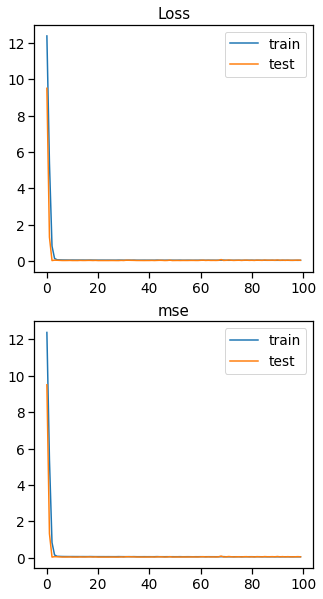

In [74]:
plot_history(history, 'mse')

In [75]:
evaluate_model(y_test, preds)

{'mae': 0.12932224902841782,
 'mse': 0.044538730109394874,
 'r2': 0.9381516017237863,
 'rmse': 0.21104201029509473}

In [76]:
test_2 = test.drop(columns = 'preds')
test_2['preds'] = preds

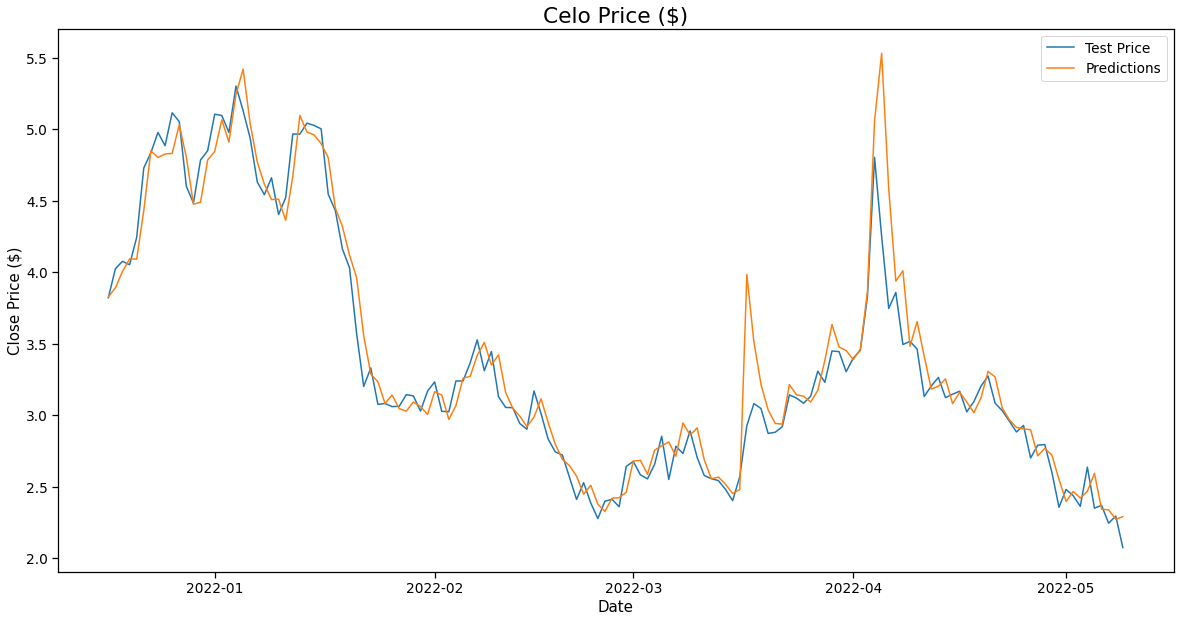

In [77]:
plot_preds(test_2)

In [120]:
model_3 = build_lstm_model(input_shape, activation = 'tanh', neurons = 90)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 4, 90)             33120     
                                                                 
 lstm_52 (LSTM)              (None, 4, 90)             65160     
                                                                 
 lstm_53 (LSTM)              (None, 90)                65160     
                                                                 
 dense_17 (Dense)            (None, 1)                 91        
                                                                 
Total params: 163,531
Trainable params: 163,531
Non-trainable params: 0
_________________________________________________________________


In [121]:
history, preds = fit_lstm(model_3, X_train_scaled, X_test_scaled, y_train, epochs = 1000, validation = [X_test_scaled, y_test], verbose = 0)

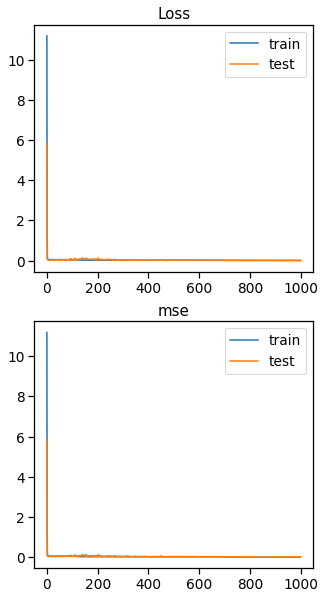

In [122]:
plot_history(history, 'mse')

In [123]:
evaluate_model(y_test, preds)

{'mae': 0.09464011258549163,
 'mse': 0.020683782636055532,
 'r2': 0.971277608876784,
 'rmse': 0.1438185754207555}

In [124]:
test_3 = test.drop(columns = 'preds')
test_3['preds'] = preds
test_3

,Open,High,Low,Close,Volume,preds
Date,,,,,,
2021-12-17,3.854962,4.035592,3.654000,3.822037,75499196,3.747530
2021-12-18,3.814436,4.235048,3.778107,4.025165,67584144,3.970460
2021-12-19,4.017936,4.242689,3.978049,4.077122,55912359,4.008977
2021-12-20,4.087582,4.404627,3.842316,4.053430,83483553,3.966073
2021-12-21,4.052707,4.411515,4.052259,4.244383,56570911,4.176322
...,...,...,...,...,...,...
2022-05-05,2.638370,2.692711,2.286656,2.351552,76615567,2.440788
2022-05-06,2.351439,2.406465,2.232458,2.370809,55646805,2.296481
2022-05-07,2.370458,2.390138,2.202498,2.246109,53472862,2.261443


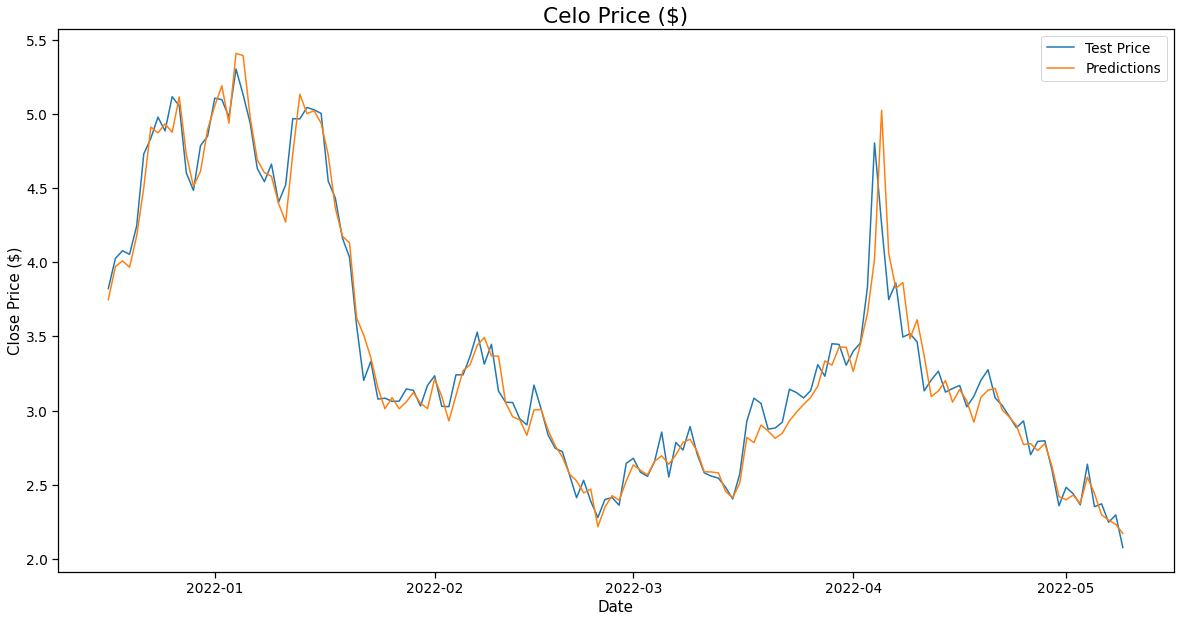

In [125]:
plot_preds(test_3)